# Where to Purchase Property in Orlando
### Neighborhood Clustering using Machine Learning

## Table of contents
* [Introduction](#introduction)
* [EDA](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction:  <a name="introduction"></a>

#### Background

Orlando is the fourth largest city in the state of Florida and the 73rd largest city in the United States. Located in Florida’s “sun belt” region, this city is known for its warm climate, beautiful beaches, and even more so for its world famous amusement parks, entertainment, and attractions. With a combined population of 3.3 million residents, Orlando’s real estate market is fueled by job seekers, baby boomer retirees, and investors.

#### Problems
Location, location, location, the most important thing to consider when purchasing property. For people looking for properties in Orlando, especially people from outside the region, they often ask the question, “Where should I start?”  There are over hundreds suburbs in Greater Orlando area, and will take a lot of time and resources for property buyers looking into each suburb. 

#### Goal
The goal is to analyze suburbs in Greater Orlando area and help property buyers to narrow down their search area.

There are three main group buyers: job seekers, retirees, and investors. Job seekers are looking for properties near job opportunities; investors are looking for properties near attractions, and retirees may be looking for properties in the area not so crowed. 

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim

from bs4 import BeautifulSoup
import requests
import json
from pandas.io.json import json_normalize

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
orlando = (28.5383, -81.3792)

## Exploratory Data Analysis: <a name="data"></a>

#### Obtain suburbs list from Wikipedia using web scraping

In [235]:
url='https://en.wikipedia.org/wiki/Greater_Orlando'    
r=requests.get(url)
soup=BeautifulSoup(r.content, 'html5lib')

In [236]:
table=soup.find_all('div', class_='div-col columns column-width')
suburbs=[]
for li in table:
    atag=li.find_all('a', href=True, attrs={'title':True, 'class':False})
    for a in atag:
        text=a['title']
        suburbs.append(text)

#### Clean up data and ensure all suburbs located within Great Oralndo Area

In [237]:
suburbs_raw=pd.DataFrame(suburbs,columns=['suburbs_name'])
suburbs_raw.head(5)

,suburbs_name
0,"Alafaya, Florida"
1,"Altamonte Springs, Florida"
2,"Apopka, Florida"
3,"Azalea Park, Florida"
4,"Buenaventura Lakes, Florida"


In [238]:
latitude = [] #Using geocoder obtain latitude and longitude of each suburbs
longitude = []
names = suburbs_raw['suburbs_name']
for name in names:
    geolocator = Nominatim(user_agent = 'orlando_explorer')
    location = geolocator.geocode(name)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

In [239]:
suburbs_raw['latitude'] = latitude
suburbs_raw['longitude'] = longitude
print(suburbs_raw.shape)
suburbs_raw.head(5)

(99, 3)


,suburbs_name,latitude,longitude
0,"Alafaya, Florida",28.564100,-81.211400
1,"Altamonte Springs, Florida",28.664905,-81.376269
2,"Apopka, Florida",28.677968,-81.511521
3,"Azalea Park, Florida",28.547361,-81.301047
4,"Buenaventura Lakes, Florida",28.331693,-81.358921


In [240]:
# map all suburbs on the map see if coordinates are correct
map_orlando = folium.Map(location=orlando, zoom_start=6)

for lat, lng, nam in zip(suburbs_raw['latitude'], suburbs_raw['longitude'], suburbs_raw['suburbs_name']):
    label = '{}'.format(nam)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_orlando)
map_orlando    

Map showed some suburbs located outside Orlando area. Next step is to clean the geolocation data and only keep the suburbs in Orange County, Seminole County, Lake County, Polk County, and Osceola County.

In [241]:
address = []  #get address from Geocoder to identify suburbs that outside Orlando area
names = suburbs_raw['suburbs_name']
for name in names:
    geolocator = Nominatim(user_agent ='orlando_explorer')
    location = geolocator.geocode(name)
    address.append(location.address)

In [242]:
suburbs=suburbs_raw.copy()
suburbs['address'] = address
suburbs['country'] = suburbs['address'].str.split(',').str[-1].str.strip()
suburbs['county'] = suburbs['address'].str.split(',').str[1].str.strip()
suburbs.head(5)

,suburbs_name,latitude,longitude,address,country,county
0,"Alafaya, Florida",28.564100,-81.211400,"Alafaya, Alafaya CDP, Orange County, Florida, ...",United States of America,Alafaya CDP
1,"Altamonte Springs, Florida",28.664905,-81.376269,"Altamonte Springs, Seminole County, Florida, U...",United States of America,Seminole County
2,"Apopka, Florida",28.677968,-81.511521,"Apopka, Orange County, Florida, United States ...",United States of America,Orange County
3,"Azalea Park, Florida",28.547361,-81.301047,"Azalea Park, Orange County, Florida, United St...",United States of America,Orange County
4,"Buenaventura Lakes, Florida",28.331693,-81.358921,"Buenaventura Lakes, Osceola County, Florida, 3...",United States of America,Osceola County


In [245]:
suburbs[suburbs['country']!='United States of America']

,suburbs_name,latitude,longitude,address,country,county


In [246]:
#Replace record with information from Wikipeida. 
suburbs.iloc[15]=['Horizon West, Florida','28.433889','-81.6225','Horizon West, Oranage County, Florida, United States of America','United States of America' ,'Orange County']
suburbs.iloc[15]

suburbs_name                                Horizon West, Florida
latitude                                                28.433889
longitude                                                -81.6225
address         Horizon West, Oranage County, Florida, United ...
country                                  United States of America
county                                              Orange County
Name: 15, dtype: object

In [247]:
orlando_county=['Orange County', 'Seminole County', 'Lake County', 'Polk County', 'Osceola County']

In [248]:
suburbs[~suburbs['county'].isin(orlando_county)]

,suburbs_name,latitude,longitude,address,country,county
0,"Alafaya, Florida",28.5641,-81.2114,"Alafaya, Alafaya CDP, Orange County, Florida, ...",United States of America,Alafaya CDP
8,"DeLand, Florida",29.0283,-81.3031,"DeLand, Volusia County, Florida, United States...",United States of America,Volusia County
9,"Deltona, Florida",28.9005,-81.2637,"Deltona, Volusia County, Florida, United State...",United States of America,Volusia County
10,"Eustis, Florida",28.8518,-81.7109,"Eustis, Paradise Drive, Fort Mason, Lake Count...",United States of America,Paradise Drive
18,"Lake Butler, Orange County, Florida",28.4872,-81.5503,"Lake Butler, South Lake Sawyer Lane, Summerpor...",United States of America,South Lake Sawyer Lane
28,"Orange City, Florida",28.9489,-81.2987,"Orange City, Volusia County, Florida, United S...",United States of America,Volusia County
30,"Palm Coast, Florida",29.5541,-81.2208,"Palm Coast, Flagler County, Florida, United St...",United States of America,Flagler County
32,"Pine Hills, Florida",28.5826,-81.4618,"Pine Hills, Clarcona, Orange County, Florida, ...",United States of America,Clarcona
33,"Poinciana, Florida",28.1743,-81.4932,"Poinciana, South Orange Blossom Trail, Interce...",United States of America,South Orange Blossom Trail
37,"Titusville, Florida",28.6122,-80.8076,"Titusville, Brevard County, Florida, United St...",United States of America,Brevard County


In [249]:
suburbs=suburbs[(suburbs['county']!='Flagler County')&(suburbs['county']!='Volusia County')&(suburbs['county']!='Brevard County')]
suburbs.loc[[0,18,32,33,38,45,46,63,65,87,88,89],'county']='Orange County'
suburbs.loc[[10,77,82],'county']='Lake County'
suburbs.loc[[50],'county']='Osceola County'
suburbs.loc[[62],'county']='Seminole County'
suburbs['suburbs_name']=suburbs['suburbs_name'].str.split(',').str[0] + ', '+suburbs['county']+', FL'
suburbs.county.unique()

array(['Orange County', 'Seminole County', 'Osceola County',
       'Lake County', 'Polk County'], dtype=object)

In [250]:

map_orlando = folium.Map(location=orlando, zoom_start=8)  #map suburbs with new coordinates

for lat, lng, nam in zip(suburbs['latitude'], suburbs['longitude'], suburbs['suburbs_name']):
    label = '{}'.format(nam)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_orlando)
map_orlando 

In [251]:
suburbs=suburbs[suburbs['suburbs_name']!='Yeehaw Junction, Osceola County, FL'] #Yeehaw Junction, Osceola County, FL is away from all other locations, remove it from the dataset

We cleaned the data set and have all suburbs within Orlando area. Now we can analyze each suburb.

## Methodology:  <a name="methodology"></a>

Based on research done by Orlando Real Estate Association, the property buyers can be categorized into three groups: job seekers, retirees, and investors. In general, job seekers prefer properties near business; retirees prefer properties near shops and activities; and investors prefer properties near attractions. 

One way to find some insights of each suburbs is to look at the venues nearby. Is it close to attraction or is it closed to shops?

I have collected name and location of suburbs withiin great Orlando area, next step is to explore venues near each suburb, using k-means clustering to group suburbs based on top recommended venues. 

## Analysis:  <a name="analysis"></a>

#### Explore venues near each suburbs using FourSquare explore API. 

In [252]:
def getNearbyVenues (names, latitudes, longitudes): #create function obtain venues name and categories from Foursquare
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Suburbs Name', 
                                 'Suburbs Lat', 
                                 'Suburbs Log', 
                                 'Venue', 
                                 'Venue Lat', 
                                 'Venue Log', 
                                 'Venue Category']
    return(nearby_venues)

In [253]:
CLIENT_ID = 'id'  # credential removed before sharing
CLIENT_SECRET = 'secret' 
VERSION = '20180605' 
LIMIT = 100

In [254]:
venues = getNearbyVenues(names = suburbs['suburbs_name'], 
                         latitudes = suburbs['latitude'], 
                         longitudes = suburbs['longitude'])

Alafaya, Orange County, FL
Altamonte Springs, Seminole County, FL
Apopka, Orange County, FL
Azalea Park, Orange County, FL
Buenaventura Lakes, Osceola County, FL
Casselberry, Seminole County, FL
Clermont, Lake County, FL
Conway, Orange County, FL
Eustis, Lake County, FL
Fairview Shores, Orange County, FL
Four Corners, Polk County, FL
Goldenrod, Orange County, FL
Groveland, Lake County, FL
Horizon West, Orange County, FL
Hunter's Creek, Orange County, FL
Lady Lake, Lake County, FL
Lake Butler, Orange County, FL
Lake Mary, Seminole County, FL
Leesburg, Lake County, FL
Lockhart, Orange County, FL
Longwood, Seminole County, FL
Maitland, Orange County, FL
Meadow Woods, Orange County, FL
Mount Dora, Lake County, FL
Oak Ridge, Orange County, FL
Ocoee, Orange County, FL
Oviedo, Seminole County, FL
Pine Castle, Orange County, FL
Pine Hills, Orange County, FL
Poinciana, Orange County, FL
St. Cloud, Osceola County, FL
Southchase, Orange County, FL
Tavares, Lake County, FL
University, Orange Count

In [255]:
print(venues.shape)
venues.head(1)

(7759, 7)


,Suburbs Name,Suburbs Lat,Suburbs Log,Venue,Venue Lat,Venue Log,Venue Category
0,"Alafaya, Orange County, FL",28.5641,-81.2114,Mellow Mushroom,28.566586,-81.209926,Pizza Place


Let's take a look at data we obtained from Foursqure

In [256]:
venues.groupby('Suburbs Name')['Suburbs Name'].count().describe()

count     90.000000
mean      86.211111
std       27.080610
min        9.000000
25%       93.250000
50%      100.000000
75%      100.000000
max      100.000000
Name: Suburbs Name, dtype: float64

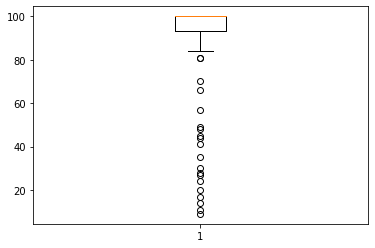

In [257]:
count= venues.groupby('Suburbs Name')['Suburbs Name'].count()
plt.boxplot(count)
plt.show()

Using boxplot, we can easily visualize that majority suburbs have 100 venues (max venues can be pulled) returend. However, there are some suburbs have less than 100 venues and showing as outlier of our data. We can first classify all of suburbs into two group. One group with suburbs have over 86 venues as popular suburbs surrounded by a lot of venues, another group has less than 86 venues as least popular suburbs. 

Let's splt the dataset into two group based on venues returen.

In [258]:
cluster = venues.groupby('Suburbs Name').filter(lambda x: x['Venue Category'].count()>86)
cluster_n = venues.groupby('Suburbs Name').filter(lambda x: x['Venue Category'].count()<=86)
print('Popular Suburbs:', len(cluster['Suburbs Name'].unique()))  
print('Least Poplular Suburbs: ',len(cluster_n['Suburbs Name'].unique()))

Popular Suburbs: 69
Least Poplular Suburbs:  21


Let's look into more details of popular suburbs group. 

In [259]:
print(len(venues['Venue Category'].unique()))
venues['Venue Category'].unique()[0:10]

333


array(['Pizza Place', 'Market', 'Japanese Restaurant', 'Ice Cream Shop',
       'Mexican Restaurant', 'Fabric Shop', 'Coffee Shop',
       'Sporting Goods Shop', 'Caribbean Restaurant',
       'Chinese Restaurant'], dtype=object)

There are 333 unique venues categories in the data set. However, for property buyers, these categories are too granulate. Next step is to use Foursquare category hierarchy to group these categories to a higher level. 

In [260]:
category = pd.read_excel('cat.xlsx')  #import Foursquare category file
print(category.shape)
category.head(1)

(937, 2)


,Cat Group,Venue Category
0,Arts & Entertainment,Amphitheater


In [261]:
orlando_venues = pd.merge(cluster, category, on = 'Venue Category', how = 'left') # Adding primary category (Cat Group) to data set 
print(orlando_venues.shape)
orlando_venues.head(5)

(6878, 8)


,Suburbs Name,Suburbs Lat,Suburbs Log,Venue,Venue Lat,Venue Log,Venue Category,Cat Group
0,"Alafaya, Orange County, FL",28.5641,-81.2114,Mellow Mushroom,28.566586,-81.209926,Pizza Place,Food
1,"Alafaya, Orange County, FL",28.5641,-81.2114,Lucky's Market,28.565752,-81.209459,Market,Shop & Service
2,"Alafaya, Orange County, FL",28.5641,-81.2114,Kobe Japanese Steakhouse - Alafaya,28.567924,-81.210676,Japanese Restaurant,Food
3,"Alafaya, Orange County, FL",28.5641,-81.2114,Jeremiah's Italian Ice,28.557320,-81.205330,Ice Cream Shop,Food
4,"Alafaya, Orange County, FL",28.5641,-81.2114,Chuys Tex Mex,28.563235,-81.207764,Mexican Restaurant,Food


Analyze venues at each suburbs, sort venues based on number of each category

In [276]:
orlando_venues_oh = pd.get_dummies(orlando_venues[['Cat Group']], prefix='', prefix_sep='')
orlando_venues_oh ['Suburbs Name'] = orlando_venues['Suburbs Name'] 
orlando_venues_grouped = orlando_venues_oh.groupby('Suburbs Name').mean().reset_index()
orlando_venues_grouped.head(5)

,Suburbs Name,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,"Alafaya, Orange County, FL",0.04,0.00,0.55,0.02,0.04,0.0,0.0,0.35,0.00
1,"Altamonte Springs, Seminole County, FL",0.03,0.00,0.51,0.02,0.07,0.0,0.0,0.36,0.01
2,"Apopka, Orange County, FL",0.01,0.00,0.46,0.01,0.13,0.0,0.0,0.37,0.02
3,"Azalea Park, Orange County, FL",0.01,0.01,0.53,0.02,0.08,0.0,0.0,0.35,0.00
4,"Bay Hill, Orange County, FL",0.12,0.00,0.53,0.05,0.05,0.0,0.0,0.22,0.03


In [277]:
size = len(orlando_venues['Cat Group'].unique())
i=1
columns = ['Suburbs Name']
for i in range (i,size+1):
    columns.append(i)
columns 

['Suburbs Name', 1, 2, 3, 4, 5, 6, 7, 8, 9]

Sort venues based on number of venues in each suburbs. 

In [278]:
def venues_sorted(row, size):
    row = row.iloc[1:]
    row_sorted = row.sort_values(ascending = False)
    return row_sorted.index.values[0:size]
orlando_venues_gp_sorted = pd.DataFrame(columns = columns)
orlando_venues_gp_sorted['Suburbs Name'] = orlando_venues_grouped['Suburbs Name']
for i in np.arange(orlando_venues_grouped.shape[0]):
    orlando_venues_gp_sorted.iloc[i,1:] = venues_sorted(orlando_venues_grouped.iloc[i,:], size)
orlando_venues_gp_sorted.head(1)    


,Suburbs Name,1,2,3,4,5,6,7,8,9
0,"Alafaya, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University


#### Clustering

Finding best K

In [279]:
orlando_surburbs_cluster = orlando_venues_grouped.drop('Suburbs Name', axis = 1)
x = []
y = []
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(orlando_surburbs_cluster)
    k_label = kmeans.labels_
    cost = kmeans.inertia_
    x.append(k)
    y.append(cost)
    print(k, cost)

1 2.0569653065502798
2 1.2164301925461825
3 0.6379157676188711
4 0.516334865728914
5 0.4547090795184589
6 0.3736674644252981
7 0.32717360411484875
8 0.28646251492737757
9 0.2589970417113955


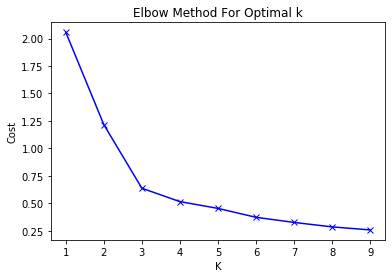

In [280]:
plt.plot(x,y, 'bx-')
plt.xlabel('K')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Now that we determined the optimal k is 3. let's use k-means clustering to group the suburbs.

In [281]:
suburbs_new=suburbs[['suburbs_name','latitude','longitude']]
kclusters = 3
orlando_surburbs_cluster = orlando_venues_grouped.drop('Suburbs Name', axis = 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(orlando_surburbs_cluster)
k_label = kmeans.labels_
orlando_venues_gp_sorted['k_label'] = k_label
orlando_venues_gp_sorted = pd.merge(orlando_venues_gp_sorted, suburbs_new, left_on = 'Suburbs Name', right_on = 'suburbs_name')
orlando_venues_gp_sorted = orlando_venues_gp_sorted.drop('suburbs_name', axis = 1)
orlando_venues_gp_sorted.head(5)

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
0,"Alafaya, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.5641,-81.2114
1,"Altamonte Springs, Seminole County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.6649,-81.3763
2,"Apopka, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places,College & University,0,28.678,-81.5115
3,"Azalea Park, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,0,28.5474,-81.301
4,"Bay Hill, Orange County, FL",Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.4645,-81.5097


Now let's bring back the least poplular suburbs to the dataset, and formate the data the same as popular suburbs.

In [282]:
cluster_n = pd.merge(cluster_n, category, on = 'Venue Category', how = 'left') # Adding primary category (Cat Group) to data set 
cluster_n_onehot = pd.get_dummies(cluster_n[['Cat Group']], prefix='', prefix_sep='')
cluster_n_onehot ['Suburbs Name'] = cluster_n['Suburbs Name'] 
cluster_n_grouped = cluster_n_onehot.groupby('Suburbs Name').mean().reset_index()
cluster_n_sorted = pd.DataFrame(columns = columns)
cluster_n_sorted['Suburbs Name'] = cluster_n_grouped['Suburbs Name']
for i in np.arange(cluster_n_grouped.shape[0]):
    cluster_n_sorted.iloc[i,1:] = venues_sorted(cluster_n_grouped.iloc[i,:], size)
i=3
cluster_n_sorted['k_label']=i
cluster_n=pd.merge(cluster_n_sorted, suburbs_new, left_on = 'Suburbs Name', right_on = 'suburbs_name', how = 'left')
cluster_n=cluster_n.drop('suburbs_name', axis=1)
print(cluster_n.shape)
cluster_n.head(5)    

(21, 13)


,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
0,"Altoona, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot,College & University,Arts & Entertainment,3,28.9678,-81.6478
1,"Astatula, Lake County, FL",Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot,Residence,College & University,3,28.7097,-81.7329
2,"Astor, Lake County, FL",Outdoors & Recreation,Food,Nightlife Spot,Travel & Transport,Shop & Service,Residence,Professional & Other Places,College & University,Arts & Entertainment,3,29.164,-81.5359
3,"Christmas, Orange County, FL",Outdoors & Recreation,Shop & Service,Travel & Transport,Arts & Entertainment,Professional & Other Places,Food,Residence,Nightlife Spot,College & University,3,28.5205,-80.9978
4,"Chuluota, Seminole County, FL",Food,Shop & Service,Outdoors & Recreation,College & University,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,3,28.6383,-81.1154


Combine two dataset into one

In [283]:
orlando_venues_gp_sorted = orlando_venues_gp_sorted.append(cluster_n, sort=False)
orlando_venues_gp_sorted.head()

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
0,"Alafaya, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.5641,-81.2114
1,"Altamonte Springs, Seminole County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.6649,-81.3763
2,"Apopka, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places,College & University,0,28.678,-81.5115
3,"Azalea Park, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,0,28.5474,-81.301
4,"Bay Hill, Orange County, FL",Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.4645,-81.5097


## Results<a name="results"></a>

In [284]:
print('Total suburbs: ', orlando_venues_gp_sorted.shape[0])
print('Total cluster: ', len(orlando_venues_gp_sorted['k_label'].unique()))

Total suburbs:  90
Total cluster:  4


Let's see how it looks on the map.

In [285]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_orlando = folium.Map(location = orlando, zoom_start = 9)

x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(orlando_venues_gp_sorted['latitude'],orlando_venues_gp_sorted['longitude'], orlando_venues_gp_sorted['Suburbs Name'], orlando_venues_gp_sorted['k_label'] ):
    label = folium.Popup(str(poi)+'Cluster'+str(cluster), paser_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=[rainbow[cluster-1]],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_orlando)
map_orlando

In [286]:
result=orlando_venues_gp_sorted.groupby('k_label')['k_label'].count()
result

k_label
0    44
1     6
2    19
3    21
Name: k_label, dtype: int64

Let's find out how many suburbs in each cluster

In [287]:
cluster_0 = orlando_venues_gp_sorted.loc[orlando_venues_gp_sorted['k_label']==0, orlando_venues_gp_sorted.columns]
cluster_0

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
0,"Alafaya, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.5641,-81.2114
1,"Altamonte Springs, Seminole County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.6649,-81.3763
2,"Apopka, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places,College & University,0,28.678,-81.5115
3,"Azalea Park, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,College & University,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,0,28.5474,-81.301
4,"Bay Hill, Orange County, FL",Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.4645,-81.5097
7,"Bithlo, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.5546,-81.1067
9,"Campbell, Osceola County, FL",Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Residence,College & University,Arts & Entertainment,0,28.2602,-81.4529
12,"Clermont, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,0,28.5388,-81.7343
13,"Conway, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Travel & Transport,Residence,College & University,Arts & Entertainment,0,28.5024,-81.3309
14,"Eatonville, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Professional & Other Places,Residence,College & University,0,28.6187,-81.3861


In [288]:
cluster_0_map = folium.Map(location = orlando, zoom_start = 9)

for lat, lon, poi, cluster in zip(cluster_0['latitude'],cluster_0['longitude'], cluster_0['Suburbs Name'], cluster_0['k_label'] ):
    label = folium.Popup(str(poi)+'Cluster'+str(cluster), paser_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(cluster_0_map)
cluster_0_map

Cluster 0 consist 47 suburbs. First venue in this group is food which indicates these suburbs are very popular residential areas. These suburbs are good choice for retirees and job seekers as well.  

In [289]:
cluster_1 = orlando_venues_gp_sorted.loc[orlando_venues_gp_sorted['k_label']==1, orlando_venues_gp_sorted.columns]
cluster_1

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
5,"Bay Lake, Orange County, FL",Arts & Entertainment,Food,Travel & Transport,Shop & Service,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,College & University,1,28.3876,-81.5749
11,"Celebration, Osceola County, FL",Travel & Transport,Food,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Nightlife Spot,Residence,Professional & Other Places,College & University,1,28.3123,-81.5541
19,"Four Corners, Polk County, FL",Food,Travel & Transport,Shop & Service,Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,Residence,Professional & Other Places,College & University,1,28.3461,-81.6734
25,"Horizon West, Orange County, FL",Arts & Entertainment,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Residence,Professional & Other Places,College & University,1,28.433889,-81.6225
28,"Lake Buena Vista, Orange County, FL",Shop & Service,Food,Arts & Entertainment,Nightlife Spot,Travel & Transport,Outdoors & Recreation,Professional & Other Places,Residence,College & University,1,28.3803,-81.5298
62,"Williamsburg, Orange County, FL",Arts & Entertainment,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Residence,Professional & Other Places,College & University,1,28.4051,-81.4465


In [290]:
cluster_1_map = folium.Map(location = orlando, zoom_start = 10)

for lat, lon, poi, cluster in zip(cluster_1['latitude'],cluster_1['longitude'], cluster_1['Suburbs Name'], cluster_1['k_label'] ):
    label = folium.Popup(str(poi)+'Cluster'+str(cluster), paser_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7).add_to(cluster_1_map)
cluster_1_map

Cluster 1 consist 6 suburbs. Art and Entertainment are top venues in this cluster. On the map, we can find these suburbs near Disney and Universal. These suburbs are choices for the investors. 

In [291]:
cluster_2 = orlando_venues_gp_sorted.loc[orlando_venues_gp_sorted['k_label']==2, orlando_venues_gp_sorted.columns]
cluster_2

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
6,"Belle Isle, Orange County, FL",Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places,College & University,2,28.4622,-81.3601
8,"Buenaventura Lakes, Osceola County, FL",Shop & Service,Food,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot,College & University,2,28.3317,-81.3589
10,"Casselberry, Seminole County, FL",Shop & Service,Food,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,College & University,2,28.6543,-81.3238
16,"Eustis, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Arts & Entertainment,Residence,Professional & Other Places,College & University,2,28.8518,-81.7109
17,"Fairview Shores, Orange County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Travel & Transport,Arts & Entertainment,Residence,Professional & Other Places,College & University,2,28.5911,-81.3942
18,"Fern Park, Seminole County, FL",Shop & Service,Food,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Travel & Transport,Residence,Professional & Other Places,College & University,2,28.6492,-81.3512
32,"Leesburg, Lake County, FL",Shop & Service,Food,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Residence,Professional & Other Places,College & University,Arts & Entertainment,2,28.8108,-81.8779
36,"Meadow Woods, Orange County, FL",Shop & Service,Food,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot,College & University,2,28.3704,-81.3576
41,"Oak Ridge, Orange County, FL",Shop & Service,Food,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,College & University,2,28.4711,-81.4245
47,"Pine Castle, Orange County, FL",Shop & Service,Food,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Residence,Professional & Other Places,College & University,2,28.4713,-81.3683


In [292]:
cluster_2_map = folium.Map(location = orlando, zoom_start = 10)

for lat, lon, poi, cluster in zip(cluster_2['latitude'],cluster_2['longitude'], cluster_2['Suburbs Name'], cluster_2['k_label'] ):
    label = folium.Popup(str(poi)+'Cluster'+str(cluster), paser_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(cluster_2_map)
cluster_2_map

Cluster 2 consist 18 suburbs. Compare to Cluster 0, suburbs in this cluster has shops at first place and food at second. This indicates more business located in these areas. These suburbs are good choice for job seekers.

In [293]:
cluster_3 = orlando_venues_gp_sorted.loc[orlando_venues_gp_sorted['k_label']==3, orlando_venues_gp_sorted.columns]
cluster_3

,Suburbs Name,1,2,3,4,5,6,7,8,9,k_label,latitude,longitude
0,"Altoona, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot,College & University,Arts & Entertainment,3,28.9678,-81.6478
1,"Astatula, Lake County, FL",Outdoors & Recreation,Food,Shop & Service,Arts & Entertainment,Travel & Transport,Professional & Other Places,Nightlife Spot,Residence,College & University,3,28.7097,-81.7329
2,"Astor, Lake County, FL",Outdoors & Recreation,Food,Nightlife Spot,Travel & Transport,Shop & Service,Residence,Professional & Other Places,College & University,Arts & Entertainment,3,29.164,-81.5359
3,"Christmas, Orange County, FL",Outdoors & Recreation,Shop & Service,Travel & Transport,Arts & Entertainment,Professional & Other Places,Food,Residence,Nightlife Spot,College & University,3,28.5205,-80.9978
4,"Chuluota, Seminole County, FL",Food,Shop & Service,Outdoors & Recreation,College & University,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,3,28.6383,-81.1154
5,"Ferndale, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Professional & Other Places,Travel & Transport,Residence,College & University,3,28.6216,-81.7003
6,"Geneva, Seminole County, FL",Outdoors & Recreation,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,College & University,3,28.7373,-81.1134
7,"Groveland, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,Travel & Transport,Residence,Professional & Other Places,College & University,3,28.5581,-81.8512
8,"Howey-in-the-Hills, Lake County, FL",Food,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Arts & Entertainment,Residence,Nightlife Spot,College & University,3,28.7169,-81.7734
9,"Lake Kathryn, Lake County, FL",Outdoors & Recreation,Shop & Service,Food,Travel & Transport,Residence,Professional & Other Places,Nightlife Spot,College & University,Arts & Entertainment,3,29.0153,-81.4915


In [294]:
cluster_3_map = folium.Map(location = orlando, zoom_start = 10)

for lat, lon, poi, cluster in zip(cluster_3['latitude'],cluster_3['longitude'], cluster_3['Suburbs Name'], cluster_3['k_label'] ):
    label = folium.Popup(str(poi)+'Cluster'+str(cluster), paser_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(cluster_3_map)
cluster_3_map

Cluster 3 consist 22 suburbs. We first identified this group due to its lack of venues returned from Foursquare. The map also showed these suburbs locate outskirts of the city and many of them near national parks. These suburbs are good choice for retirees looking for property away from city crowed. 

## Conclusion <a name="conclusion"></a>

Based on my knowledge of Orlando area, I found the model provide a good insight on Orlando suburbs based on nearby venues. Suburbs in Cluster 0 are well known residential areas with a lot of restaurants, shops and activities. Cluster 1 suburbs are near Disney and Universal theme park. Suburbs in Cluster 2 are less popular neighborhood compare to cluster 0. Cluster 3 was identified first based on less venues returned during venue exploration, and they are indeed far away from city centers. 
The model can be further improved if I can fine tune the category from property buyer’s perspective instead of using Foursquare category hierarchy. 